In [1]:
!pip install --upgrade matplotlib

In [2]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from numpy.random import seed

In [3]:
stocks = pd.read_csv('stocks.csv', index_col=0)
stocks.head()

,btcClose,ethClose,adaClose
date,,,
2017-10-01,4403.740234,302.337006,0.024969
2017-10-02,4409.319824,297.475006,0.025932
2017-10-03,4317.479980,292.463013,0.020816
2017-10-04,4229.359863,292.657990,0.021931
2017-10-05,4328.410156,295.863007,0.021489


In [4]:
n_features = stocks.shape[1]

In [5]:
import seaborn as sns
from sklearn.metrics import mean_squared_error

def build_prediction_dataframe(training_ts, predictions_ts):
  last_training_predictions = [training_ts.tail(1), predictions_ts]
  last_training_predictions_ts = pd.concat(last_training_predictions)
  last_training_predictions_df = last_training_predictions_ts.reset_index()
  last_training_predictions_df['positive_delta'] = last_training_predictions_df.apply(lambda row: row.name > 0 and last_training_predictions_df.loc[row.name-1, :][last_training_predictions_df.columns[1]] < row[last_training_predictions_df.columns[1]], axis=1)
  predictions_df = last_training_predictions_df.iloc[1: , :][['positive_delta']]
  return predictions_df

def add_row_confusion_matrix(list_of_cm, df_row):
  row = 0
  column = 0
  if df_row.positive_delta_predict:
    column = 1
  if df_row.positive_delta_actual:
    row = 1
  list_of_cm[df_row.name-1][row, column] += 1
  return list_of_cm

def evaluate(model, ts, n_evaluations=10, n_test=3, n_steps=1, n_epochs=100, batch_size=16):
  total_hits = 0
  total_tries = 0
  confusion_matrix = [np.zeros((2,2)), np.zeros((2,2)), np.zeros((2,2))]
  train_evaluate = ts[:-n_evaluations*n_test]
  last_training = train_evaluate[-n_steps:]
  print('Iteration 1 started')
  model.train(train_evaluate, n_epochs, batch_size)

  for i in reversed(range(1, n_evaluations + 1)):
    test_evaluate = ts[-n_test*i:]
    test_evaluate = test_evaluate[:n_test]
    steps_to_predict = pd.concat([last_training, test_evaluate])

    predictions = model.predict(steps_to_predict)
    predictions = predictions.reshape(predictions.shape[0])
    predictions_ts = pd.DataFrame({test_evaluate.columns[0]: predictions}, test_evaluate.index)

    predictions_df = build_prediction_dataframe(last_training, predictions_ts)
    predictions_df.rename(columns={'positive_delta': 'positive_delta_predict'}, inplace=True)

    test_df = build_prediction_dataframe(last_training, test_evaluate)
    test_df.rename(columns={'positive_delta': 'positive_delta_actual'}, inplace=True)

    predictions_and_test = pd.concat([test_df, predictions_df], axis=1)
    predictions_and_test['equal'] = predictions_and_test.apply(lambda row: row['positive_delta_actual'] == row['positive_delta_predict'], axis=1)
    predictions_and_test.apply(lambda row: add_row_confusion_matrix(confusion_matrix, row), axis=1)

    hits = predictions_and_test['equal'].sum()
    print('Accuracy: {}/{}'.format(hits, predictions_and_test.shape[0]))
    total_hits += hits
    total_tries += predictions_and_test.shape[0]

    print('Iteration {} started'.format(n_evaluations+1-i))
    new_train = pd.concat([last_training, test_evaluate])
    model.retrain(new_train, epochs=1, batch_size=len(new_train), validation_split=0)
    last_training = new_train[-n_steps:]

  print('Total hits: {}. Total tries: {}. Accuracy: {:0.2f}'.format(total_hits, total_tries, total_hits / total_tries))
  
  return confusion_matrix

def plot_confusion_matrix(confusion_matrix):
  fig, axs = plt.subplots(2, 2)
  fig.supxlabel('Predicted')
  fig.supylabel('Actual')
  for i in range(0, len(confusion_matrix)):
    ax = axs[int(i/2), i%2]
    ax.title.set_text('Index {}'.format(i+1))
    sns.heatmap(data=confusion_matrix[i], annot=True, cbar=False, ax=ax)
  sum_cm = sum(confusion_matrix)
  axs[1,1].title.set_text('Total')
  sns.heatmap(data=sum_cm, annot=True, cbar=False, ax=axs[1,1])

def print_effectiveness_day(cm, day):
  hits = cm[0][0] + cm[1][1]
  total = hits + cm[0][1] + cm[1][0]
  print("Day:", day, "Accuracy:", hits / total)

def print_effectiveness_by_day(confusion_matrix_list):
  for i in range(len(confusion_matrix_list)):
    print_effectiveness_day(confusion_matrix_list[i], i+1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 100)               21600     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 21,701
Trainable params: 21,701
Non-trainable params: 0
_________________________________________________________________
None
Iteration 1 started
Epoch 1/60
61/61 [==============================] - 3s 13ms/step - loss: 0.0284 - accuracy: 0.0010 - val_loss: 0.0077 - val_accuracy: 0.0000e+00
Epoch 2/60
61/61 [==============================] - 0s 7ms/step - loss: 0.0033 - accuracy: 0.0010 - val_loss: 4.3038e-04 - val_accuracy: 0.0000e+00
Epoch 3/60
61/61 [==============================] - 0s 6ms/step - loss: 0.0016 - accuracy: 0.0010 - val_loss: 4.8872e-04 - val_accuracy: 0.0000e+00
Epoch 4/60
61/61 [==============================

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in double_scalars


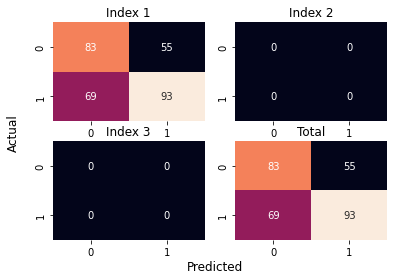

In [6]:
# from sklearn.metrics import mean_absolute_percentage_error
from VanillaMultivariableLSTM import VanillaLSTM
from StackedMultivariableLSTM import StackedLSTM
from BidirectionalMultivariableLSTM import BidirectionalLSTM
from ConvMultivariableLSTM import ConvLSTM
from CnnMultivariableLSTM import CnnLSTM

epochs = 60
batch_size = 16
n_steps = 5
n_outputs = 1
n_evaluations = 300
n_neurons = 50
n_seed = 250
optimizer = 'adam'
loss = 'mean_squared_error'

seed(n_seed)
tf.random.set_seed(n_seed)
model = BidirectionalLSTM(n_neurons=n_neurons, n_steps=n_steps, n_features=3, n_outputs=n_outputs, loss=loss, optimizer=optimizer)

cm = evaluate(model, stocks, n_evaluations=n_evaluations, n_test=n_outputs, n_steps=n_steps, n_epochs=epochs, batch_size=batch_size)
plot_confusion_matrix(cm)
print_effectiveness_by_day(cm)

In [7]:
model.export_model()

In [8]:
def score_from_cm(confusion_matrix_array):
  total_cm = sum(confusion_matrix_array)
  total_score = total_cm[0][0] + total_cm[1][1]

  score_by_index = [x[0][0] + x[1][1] for x in confusion_matrix_array]
  score =  { 
      'total_score': total_score,
      'score_by_index': score_by_index
    }
  return score

def score_model_from_dict(score_dict):
  n_index = len(score_dict['score_by_index'])
  score = score_dict['total_score'] * pow(10, n_index * 2)
  for i in range(n_index):
    score += score_dict['score_by_index'][i] * pow(10, (n_index-(i+1))*2)
  print("score:", score)
  return score

def take_score(elem):
    return elem['score']

def grid_search(model_class, ts, n_features, seeds=[0], optimizers=['adam'], losses=['mean_squared_error'], neurons=[50], steps=[1], n_outputs=3, epochs=[50], batch_sizes=[16], n_evaluations=10):
  models= list()
  n_combinations = len(seeds) * len(optimizers) * len(losses) * len(neurons) * len(steps) * len(epochs) * len(batch_sizes)
  print("Number of combinations to test:", n_combinations)
  starting_time = time.time()
  for n_seed in seeds:
    for optimizer in optimizers:
      for loss in losses:
        for n_neurons in neurons:
          for n_steps in steps:
            for n_epochs in epochs:
              for batch_size in batch_sizes:
                print("Seed: {}, Optimizer: {}, Neurons: {}, Steps: {}, Epochs: {}, Batch: {}".format(n_seed, optimizer, n_neurons, n_steps, n_epochs, batch_size))
                epoch_starting_time = time.time()
                seed(n_seed)
                tf.random.set_seed(n_seed)
                model = model_class(n_neurons=n_neurons, n_features=n_features, n_steps=n_steps, n_outputs=n_outputs, loss=loss, optimizer=optimizer)
                confusion_matrix = evaluate(model, ts, n_evaluations=n_evaluations, n_test=n_outputs, n_steps=n_steps, n_epochs=n_epochs)
                score_dict = score_from_cm(confusion_matrix)
                score = score_model_from_dict(score_dict)
                parameters = {
                    'model': str(model_class),
                    'seed': n_seed,
                    'optimizer': str(optimizer),
                    'loss': loss,
                    'neurons': n_neurons,
                    'steps': n_steps,
                    'epochs': n_epochs,
                    'batch_size': batch_size
                }
                model_score = {
                    'model': model,
                    'parameters': parameters,
                    'score': score,
                    'cm': confusion_matrix
                }
                models.append(model_score)
                models = sorted(models, key=take_score, reverse=True)
                print("Combinations tested", len(models), "/", n_combinations)
                epoch_ending_time = time.time()
                print("Epoch time(s):", epoch_ending_time - epoch_starting_time)
                print("Time since starting(min):", (epoch_ending_time - starting_time) / 60)
                models_left = n_combinations - len(models)
                time_per_model_s = (epoch_ending_time - starting_time) / len(models)
                print("Time left (min):", (time_per_model_s * models_left) / 60)
  return models

In [10]:
models = grid_search(VanillaLSTM, stocks, n_features=n_features, seeds=[0], steps=[5, 6, 7], epochs=[50, 60, 70], neurons=[30, 40, 50], n_outputs=n_outputs, n_evaluations=n_evaluations, optimizers=['adam'], losses=['mean_squared_error'])

Number of combinations to test: 27
Seed: 0, Optimizer: adam, Neurons: 30, Steps: 5, Epochs: 50, Batch: 16
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 30)                4080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 31        
Total params: 4,111
Trainable params: 4,111
Non-trainable params: 0
_________________________________________________________________
None
Iteration 1 started
Epoch 1/50
61/61 [==============================] - 2s 8ms/step - loss: 0.0309 - accuracy: 0.0010 - val_loss: 0.0023 - val_accuracy: 0.0000e+00
Epoch 2/50
61/61 [==============================] - 0s 4ms/step - loss: 0.0050 - accuracy: 0.0010 - val_loss: 0.0052 - val_accuracy: 0.0000e+00
Epoch 3/50
61/61 [==============================] - 0s 4ms/step - loss: 0.0024 - accuracy: 0.00

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Streaming output truncated to the last 5000 lines.
Epoch 68/70
61/61 [==============================] - 0s 7ms/step - loss: 7.4917e-04 - accuracy: 0.0010 - val_loss: 2.5902e-04 - val_accuracy: 0.0000e+00
Epoch 69/70
61/61 [==============================] - 0s 7ms/step - loss: 7.2147e-04 - accuracy: 0.0010 - val_loss: 2.6197e-04 - val_accuracy: 0.0000e+00
Epoch 70/70
61/61 [==============================] - 0s 7ms/step - loss: 7.2946e-04 - accuracy: 0.0010 - val_loss: 2.7944e-04 - val_accuracy: 0.0000e+00
Accuracy: 1/1
Iteration 1 started
1/1 [==============================] - 0s 6ms/step - loss: 8.1785e-05 - accuracy: 0.0000e+00
Accuracy: 0/1
Iteration 2 started
1/1 [==============================] - 0s 13ms/step - loss: 5.5383e-05 - accuracy: 0.0000e+00
Accuracy: 0/1
Iteration 3 started
1/1 [==============================] - 0s 11ms/step - loss: 1.6413e-04 - accuracy: 0.0000e+00
Accuracy: 1/1
Iteration 4 started
1/1 [==============================] - 0s 12ms/step - loss: 4.7110e-06 - 

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Streaming output truncated to the last 5000 lines.
Iteration 188 started
1/1 [==============================] - 0s 8ms/step - loss: 0.0413 - accuracy: 0.0000e+00
Accuracy: 1/1
Iteration 189 started
1/1 [==============================] - 0s 7ms/step - loss: 0.0022 - accuracy: 0.0000e+00
Accuracy: 0/1
Iteration 190 started
1/1 [==============================] - 0s 7ms/step - loss: 0.0254 - accuracy: 0.0000e+00
Accuracy: 0/1
Iteration 191 started
1/1 [==============================] - 0s 7ms/step - loss: 0.0064 - accuracy: 0.0000e+00
Accuracy: 0/1
Iteration 192 started
1/1 [==============================] - 0s 9ms/step - loss: 0.0479 - accuracy: 0.0000e+00
Accuracy: 0/1
Iteration 193 started
1/1 [==============================] - 0s 12ms/step - loss: 0.0236 - accuracy: 0.0000e+00
Accuracy: 1/1
Iteration 194 started
1/1 [==============================] - 0s 9ms/step - loss: 0.0174 - accuracy: 0.0000e+00
Accuracy: 0/1
Iteration 195 started
1/1 [==============================] - 0s 7ms/step 

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Accuracy: 1/1
Iteration 113 started
1/1 [==============================] - 0s 7ms/step - loss: 0.0095 - accuracy: 0.0000e+00
Accuracy: 1/1
Iteration 114 started
1/1 [==============================] - 0s 7ms/step - loss: 1.4661e-04 - accuracy: 0.0000e+00
Accuracy: 1/1
Iteration 115 started
1/1 [==============================] - 0s 6ms/step - loss: 0.0353 - accuracy: 0.0000e+00
Accuracy: 0/1
Iteration 116 started
1/1 [==============================] - 0s 8ms/step - loss: 0.1037 - accuracy: 0.0000e+00
Accuracy: 0/1
Iteration 117 started
1/1 [==============================] - 0s 10ms/step - loss: 0.0917 - accuracy: 0.0000e+00
Accuracy: 0/1
Iteration 118 started
1/1 [==============================] - 0s 6ms/step - loss: 0.0295 - accuracy: 0.0000e+00
Accuracy: 1/1
Iteration 119 started
1/1 [==============================] - 0s 5ms/step - loss: 0.0056 - accuracy: 0.0000e+00
Accuracy: 0/1
Iteration 120 started
1/1 [==============================] - 0s 6ms/step - loss: 0.2942 - accuracy: 0.0000

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Accuracy: 1/1
Iteration 118 started
1/1 [==============================] - 0s 11ms/step - loss: 0.0039 - accuracy: 0.0000e+00
Accuracy: 1/1
Iteration 119 started
1/1 [==============================] - 0s 6ms/step - loss: 0.0169 - accuracy: 0.0000e+00
Accuracy: 0/1
Iteration 120 started
1/1 [==============================] - 0s 14ms/step - loss: 0.2817 - accuracy: 0.0000e+00
Accuracy: 0/1
Iteration 121 started
1/1 [==============================] - 0s 7ms/step - loss: 0.3460 - accuracy: 0.0000e+00
Accuracy: 1/1
Iteration 122 started
1/1 [==============================] - 0s 7ms/step - loss: 0.0777 - accuracy: 0.0000e+00
Accuracy: 1/1
Iteration 123 started
1/1 [==============================] - 0s 15ms/step - loss: 0.0096 - accuracy: 0.0000e+00
Accuracy: 0/1
Iteration 124 started
1/1 [==============================] - 0s 7ms/step - loss: 0.0115 - accuracy: 0.0000e+00
Accuracy: 1/1
Iteration 125 started
1/1 [==============================] - 0s 11ms/step - loss: 0.0411 - accuracy: 0.0000e

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Streaming output truncated to the last 5000 lines.
Accuracy: 0/1
Iteration 31 started
1/1 [==============================] - 0s 6ms/step - loss: 3.3018e-04 - accuracy: 0.0000e+00
Accuracy: 0/1
Iteration 32 started
1/1 [==============================] - 0s 11ms/step - loss: 1.5600e-05 - accuracy: 0.0000e+00
Accuracy: 0/1
Iteration 33 started
1/1 [==============================] - 0s 7ms/step - loss: 4.9158e-04 - accuracy: 0.0000e+00
Accuracy: 0/1
Iteration 34 started
1/1 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.0000e+00
Accuracy: 0/1
Iteration 35 started
1/1 [==============================] - 0s 6ms/step - loss: 9.3347e-04 - accuracy: 0.0000e+00
Accuracy: 0/1
Iteration 36 started
1/1 [==============================] - 0s 7ms/step - loss: 0.0046 - accuracy: 0.0000e+00
Accuracy: 0/1
Iteration 37 started
1/1 [==============================] - 0s 6ms/step - loss: 1.6100e-04 - accuracy: 0.0000e+00
Accuracy: 0/1
Iteration 38 started
1/1 [====================

In [11]:
models[0]

{'cm': [array([[87., 51.],
         [77., 85.]]), array([[0., 0.],
         [0., 0.]]), array([[0., 0.],
         [0., 0.]])],
 'model': <VanillaMultivariableLSTM.VanillaLSTM at 0x7f032f9eab50>,
 'parameters': {'batch_size': 16,
  'epochs': 50,
  'loss': 'mean_squared_error',
  'model': "<class 'VanillaMultivariableLSTM.VanillaLSTM'>",
  'neurons': 50,
  'optimizer': 'adam',
  'seed': 0,
  'steps': 7},
 'score': 173720000.0}

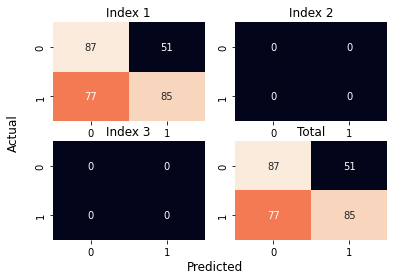

In [12]:
plot_confusion_matrix(models[0]['cm'])

In [13]:
print_effectiveness_by_day(models[0]['cm'])

Day: 1 Accuracy: 0.5733333333333334
Day: 2 Accuracy: nan
Day: 3 Accuracy: nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in double_scalars


In [16]:
models[0]['model'].export_model()